In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [14]:
data = np.loadtxt('lcparam_full_long_zhel.txt', usecols=[1,5])
print ('shape of data:',data.shape)
print(data)

shape of data: (1048, 2)
[[0.50349 0.12605]
 [0.4952  0.11765]
 [0.6782  0.2056 ]
 ...
 [1.014   0.2291 ]
 [1.315   0.1987 ]
 [1.092   0.26405]]


In [15]:
zcmb_arr = data[:, 0]
dmag_arr = data[:, 1]
print(zcmb_arr[0:10], dmag_arr[0:10])

[0.50349 0.4952  0.6782  0.8672  0.7992  0.37129 0.35568 0.28391 0.46691
 0.94791] [0.12605 0.11765 0.2056  0.17385 0.17435 0.1245  0.12645 0.1028  0.1587
 0.1642 ]


Best constrained linear combination (Omega_M, w):
[ 0.62019638 -0.78444659]
******************************************************************************
Measurement error for best constrained combination: 0.011
******************************************************************************
Least constrained linear combination (Omega_M, w):
[-0.78444659 -0.62019638]
******************************************************************************
Measurement error for least constrained combination: 0.122
******************************************************************************
The marginalized errors on Om, w are 0.096, 0.076
The unmarginalized errors on Om, w are 0.006, 0.011


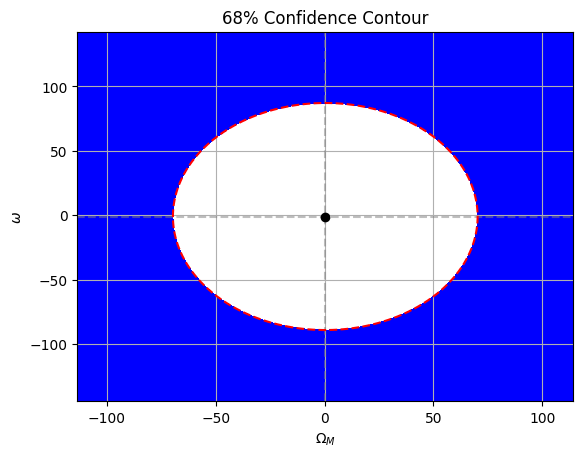

In [16]:

# Define cosmological parameters and step sizes
Om_fid = 0.3
w_fid = -1
Ok_fid = 0
dOm = 0.01
dw = 0.01
H0 = 70


# Function to calculate luminosity distance
def luminosity_distance(z, H0, Omega_M, omega):
    c = 299792.458  # Speed of light in km/s
    integral, _ = quad(lambda z_prime: 1.0 / np.sqrt(Omega_M*(1+z_prime)**3 + (1 - Omega_M - omega)*(1+z_prime)**2 + omega), 0, z)
    return (1 + z) * c  * integral

# Function to convert luminosity distance to magnitude
def luminosity_to_mag(d_L):
    return 5 * np.log10(d_L)

# Compute model predictions for fiducial parameters
d_L_fid = np.array([luminosity_distance(z, H0, Om_fid, 1 - Om_fid - Ok_fid) for z in zcmb_arr])
mag_fid = luminosity_to_mag(d_L_fid)

# Initialize Fisher matrix elements
Fisher_OM_OM = 0
Fisher_w_w = 0
Fisher_OM_w = 0

# Initialize unmarginalized errors
unmarginalized_error_Om = 0
unmarginalized_error_w = 0

# Loop over data points to calculate Fisher matrix elements
for z, mag, dmag in zip(zcmb_arr, mag_fid, dmag_arr):
    # Perturb Omega_M and calculate magnitudes
    mag_plus_dOm = luminosity_to_mag(luminosity_distance(z, H0, Om_fid + dOm, 1 - Om_fid - Ok_fid))
    mag_minus_dOm = luminosity_to_mag(luminosity_distance(z, H0, Om_fid - dOm, 1 - Om_fid - Ok_fid))
    
    # Perturb w and calculate magnitudes
    mag_plus_dw = luminosity_to_mag(luminosity_distance(z, H0, Om_fid, 1 - Om_fid - Ok_fid + dw))
    mag_minus_dw = luminosity_to_mag(luminosity_distance(z, H0, Om_fid, 1 - Om_fid - Ok_fid - dw))
    
    # Calculate derivatives
    deriv_div_by_sigma_Om = (mag_plus_dOm - mag_minus_dOm) / (2 * dOm) / dmag
    deriv_div_by_sigma_w = (mag_plus_dw - mag_minus_dw) / (2 * dw) / dmag
    
    # Update Fisher matrix elements
    Fisher_OM_OM += deriv_div_by_sigma_Om**2
    Fisher_w_w += deriv_div_by_sigma_w**2
    Fisher_OM_w += deriv_div_by_sigma_Om * deriv_div_by_sigma_w

    # Update unmarginalized errors
    unmarginalized_error_Om += (1 / deriv_div_by_sigma_Om)**2
    unmarginalized_error_w += (1 / deriv_div_by_sigma_w)**2


# Calculate unmarginalized errors
unmarginalized_error_Om = np.sqrt(1 / unmarginalized_error_Om)
unmarginalized_error_w = np.sqrt(1 / unmarginalized_error_w)
# Regularize Fisher matrix (add small diagonal offset)
epsilon = 1e-6
Fisher_matrix = np.array([[Fisher_OM_OM, Fisher_OM_w], [Fisher_OM_w, Fisher_w_w]]) + np.eye(2) * epsilon

# Diagonalize the Fisher matrix to find eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(Fisher_matrix)
order = np.argsort(eigenvalues)[::-1]  # Sort eigenvalues in descending order
eigenvalues = eigenvalues[order]
eigenvectors = eigenvectors[:, order]

# The best-constrained linear combination corresponds to the eigenvector with the largest eigenvalue
best_constrained_combination = eigenvectors[:, 0]
best_constrained_error = 1 / np.sqrt(eigenvalues[0])

# The least-constrained linear combination corresponds to the eigenvector with the smallest eigenvalue
least_constrained_combination = eigenvectors[:, 1]
least_constrained_error = 1 / np.sqrt(eigenvalues[1])

# Output the results
print("Best constrained linear combination (Omega_M, w):")
print(best_constrained_combination)
print('******************************************************************************')
print("Measurement error for best constrained combination: {:.3f}".format(best_constrained_error))
print('******************************************************************************')
print("Least constrained linear combination (Omega_M, w):")
print(least_constrained_combination)
print('******************************************************************************')
print("Measurement error for least constrained combination: {:.3f}".format(least_constrained_error))
print('******************************************************************************')
# Calculate inverse of Fisher matrix
try:
    Fisher_matrix_inv = np.linalg.inv(Fisher_matrix)
    covariance_matrix = np.linalg.inv(Fisher_matrix_inv)  # Marginalizing over M
    print("The marginalized errors on Om, w are {:.3f}, {:.3f}".format(np.sqrt(Fisher_matrix_inv[0, 0]), np.sqrt(Fisher_matrix_inv[1, 1])))
    print("The unmarginalized errors on Om, w are {:.3f}, {:.3f}".format(unmarginalized_error_Om, unmarginalized_error_w))
    # Extract standard deviations for Omega_M and w
    std_Om = np.sqrt(covariance_matrix[0, 0])
    std_w = np.sqrt(covariance_matrix[1, 1])

    # Compute correlation coefficient
    corr_coefficient = covariance_matrix[0, 1] / (std_Om * std_w)

    # Create grid of Omega_M and omega values
    Omega_M_values = Om_fid + np.linspace(-2 * std_Om, 2 * std_Om, 100)
    omega_values = w_fid + np.linspace(-2 * std_w, 2 * std_w, 100)
    Omega_M_grid, omega_grid = np.meshgrid(Omega_M_values, omega_values)

    # Calculate chi-squared values on the grid
    chi2_grid = (Omega_M_grid - Om_fid)**2 / std_Om**2 + (omega_grid - w_fid)**2 / std_w**2

    # Compute 68% confidence interval (1 sigma)
    confidence_level = 0.68
    chi2_threshold = np.sqrt(2.279)  # Chi-squared value for 1 degree of freedom at 68% confidence level
    contour_level = chi2_threshold

    # Plot contour
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$\Omega_M$')
    ax.set_ylabel(r'$\omega$')
    ax.set_title('68% Confidence Contour')
    ax.grid(True)
    ax.axhline(w_fid, color='gray', linestyle='--', alpha=0.5)  # Fiducial w
    ax.axvline(Om_fid, color='gray', linestyle='--', alpha=0.5)  # Fiducial Omega_M
    ax.contourf(Omega_M_grid, omega_grid, chi2_grid, levels=[contour_level, np.max(chi2_grid)],
                colors=['blue'], alpha=1.0)
    ax.contour(Omega_M_grid, omega_grid, chi2_grid, levels=[contour_level], colors='red', linestyles='dashed')
    ax.plot(Om_fid, w_fid, 'ko')  # Fiducial point
    ax.set_xlim(Om_fid - 2 * std_Om, Om_fid + 2 * std_Om)
    ax.set_ylim(w_fid - 2 * std_w, w_fid + 2 * std_w)
    plt.show()

except np.linalg.LinAlgError:
    print("Fisher matrix is singular. Unable to calculate marginalized errors.")
